In [1]:
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider
import cv2
import ants as ants
import matplotlib.pyplot as plt
import pydicom
from matplotlib.colors import ListedColormap
import os
import PerfusionImaging.tool as perfusion
from scipy import ndimage
import ImageTool.tool as tool
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd

# include the path to the file. 

In [2]:
root = "/home/molloi-lab-linux2/smb_mount/ImageData/Myocardial_Perfusion/High_Fat_Diet/QYZ"
target = "12_19_22_data/Pig1"
rest_sample = "Acq_01_Baseline"
save_path = os.path.join(root, target)
path_rest = os.path.join(save_path, rest_sample, "DICOM/02")
lmmask_path_rest = os.path.join(save_path, rest_sample, "SEGMENT_dcm/LEFT_MYOCARDIUM_dcm")
aorta_rest_mask = os.path.join(save_path, rest_sample, "SEGMENT_dcm/AORTA_dcm")
bolus_rest = os.path.join(save_path, rest_sample, "SureStart")

# Read the mask file (left myocardial, right myocarial, full mask, aorta)

In [ ]:
mask_rest_left = tool.load_2d_3d(lmmask_path_rest) 
mask_rest_right = tool.load_2d_3d(lmmask_path_rest.replace("LEFT", "RIGHT")) 
full_rest_mask = perfusion.mask_fun(sitk.GetArrayFromImage(mask_rest_left)) | perfusion.mask_fun(sitk.GetArrayFromImage(mask_rest_right))
full_rest_image = sitk.GetImageFromArray(full_rest_mask)
full_rest_image.CopyInformation(mask_rest_left)
dcm_mask_rest = tool.sitk2ant(full_rest_image)
dcm_mask_left = perfusion.mask_fun(tool.sitk2ant(mask_rest_left))
dcm_mask_right = perfusion.mask_fun(tool.sitk2ant(mask_rest_right))
dcm_rest_aorta = tool.sitk2ant(tool.load_2d_3d(aorta_rest_mask))

File tmp.nii has been deleted.
File tmp.nii has been deleted.
File tmp.nii has been deleted.


# Read the dcm and surestart

In [ ]:
dcm_rest = tool.sitk2ant(tool.load_2d_3d(path_rest))
ss_rest = tool.sitk2ant(tool.load_2d_3d(bolus_rest))[:] 

File tmp.nii has been deleted.
File tmp.nii has been deleted.


# Calculate HU For Aorta In V2

In [ ]:
rest_value = np.sum(dcm_rest[:] * perfusion.mask_fun(dcm_rest_aorta[:]))/np.sum(perfusion.mask_fun(dcm_rest_aorta[:]))

# Calculate the time point in surestart and v2

In [ ]:
time_v2 = perfusion.scan_time_vector([os.path.join(path_rest, i) for i in os.listdir(path_rest)])
time_ss = perfusion.scan_time_vector([os.path.join(bolus_rest, i) for i in os.listdir(bolus_rest)])
time_vec_gamma_rest = time_ss + [time_v2[len(time_v2)//2]]
time_vec_gamma_rest = [i - time_vec_gamma_rest[0] for i in time_vec_gamma_rest]

# Define some variable to store the input_conc

In [ ]:
input_conc = [0, 0]

# Find the aera under the curve as input_conc

In [ ]:
ss_rest_value = [0] * (ss_rest.shape[0] + 1)
ss_rest_value[-1] = rest_value
def plot_slice4(slice_index, x, y, r):
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    pcm = ax0.imshow(ss_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=300)
    ax0.set_title("rest")
    phi = np.linspace(0, 2 * np.pi, 100)
    circle_x = r * np.cos(phi) + x
    circle_y = r * np.sin(phi) + y
    ax0.plot(circle_x, circle_y, label=f"Aorta Mask (radius {r})", color="red", linewidth=1)
    ss_rest_value[:-1] = perfusion.compute_aif(ss_rest, x, y, r)
    # Add legend
    ax0.legend()

    try:
        
        baseline_hu = np.mean(ss_rest_value[:3])
        p0 = [0.0, baseline_hu]  # Initial guess (0, blood pool offset)

        time_vec_end, aif_vec_end = time_vec_gamma_rest[-1], ss_rest_value[-1]

        opt_params = perfusion.gamma_curve_fit(time_vec_gamma_rest, ss_rest_value, time_vec_end, aif_vec_end, p0)
        x_fit = np.linspace(np.min(time_vec_gamma_rest), np.max(time_vec_gamma_rest), 500)
        
        y_fit = perfusion.gamma(x_fit, opt_params, time_vec_end, aif_vec_end)

        baseline_hu = y_fit[0]

        # Adjust y values by subtracting baseline and taking max(0, y)
        dense_y_fit_adjusted = np.maximum(y_fit - baseline_hu, 0)

        # Compute the area under the curve using trapezoidal integration
        area_under_curve = trapezoid(dense_y_fit_adjusted, x_fit)
        # Generate a dense time vector
        # Compute input concentration
        
        input_conc[0] = area_under_curve  # Adjust for Python indexing (0-based)
        ax1.set_title("Fitted AIF Curve")
        ax1.set_xlabel("Time Point (s)")
        ax1.set_ylabel("Intensity (HU)")

        # Plot the scatter points
        ax1.scatter(time_vec_gamma_rest, ss_rest_value, label="Data Points", color="blue")
        

        # Plot the fitted curve
        ax1.plot(x_fit, y_fit, label="Fitted Curve", color="red")

        # Highlight specific points
        ax1.scatter(time_vec_gamma_rest[-2], ss_rest_value[-2], label="Trigger", color="green")
        ax1.scatter(time_vec_gamma_rest[-1], ss_rest_value[-1], label="V2", color="orange")

        # Add legend
        ax1.legend(loc="upper left")

        # Generate AUC plot
        time_temp = np.linspace(time_vec_gamma_rest[0], time_vec_gamma_rest[-1], int(np.max(time_vec_gamma_rest) * 1))

        # Create a denser AUC plot
        n_points = 1000  # Number of points for denser interpolation
        time_temp_dense = np.linspace(time_temp[0], time_temp[-1], n_points)
        auc_area_dense = perfusion.gamma(time_temp_dense, opt_params, time_vec_end, aif_vec_end) - baseline_hu

        # Add vertical lines for AUC visualization
        for i in range(len(auc_area_dense)):
            ax1.plot(
                [time_temp_dense[i], time_temp_dense[i]],
                [baseline_hu, auc_area_dense[i] + baseline_hu],
                color="cyan",
                linewidth=1,
                alpha=0.2
            )
        np.save("rest_para.npy", [x, y, r])
    except:
        pass
    # Show the plot
    plt.show()

# Creating an interactive slider
if os.path.exists("rest_para.npy"):
    x, y, r = np.load("rest_para.npy")
else:
    x, y, r = 0, 0, 8
interact(plot_slice4, slice_index=IntSlider(max=ss_rest.shape[2] - 1), x = IntSlider(min = 15, max = ss_rest.shape[0] - 15, value = x), y = IntSlider(min = 15, max = ss_rest.shape[1] - 15, value = y), r = IntSlider(max = 14, value = r))

interactive(children=(IntSlider(value=0, description='slice_index', max=13), IntSlider(value=15, description='…

<function __main__.plot_slice4(slice_index, x, y, r)>

# Choose full/left/right myocardial to calculate: 

In [ ]:
# chosen_mask = dcm_mask_rest
chosen_mask = dcm_mask_left
# chosen_mask = dcm_mask_right

# Find the mean value of HU in the first slice of the surestart

The slice number of 158 is chosen
48.230453 52.671085


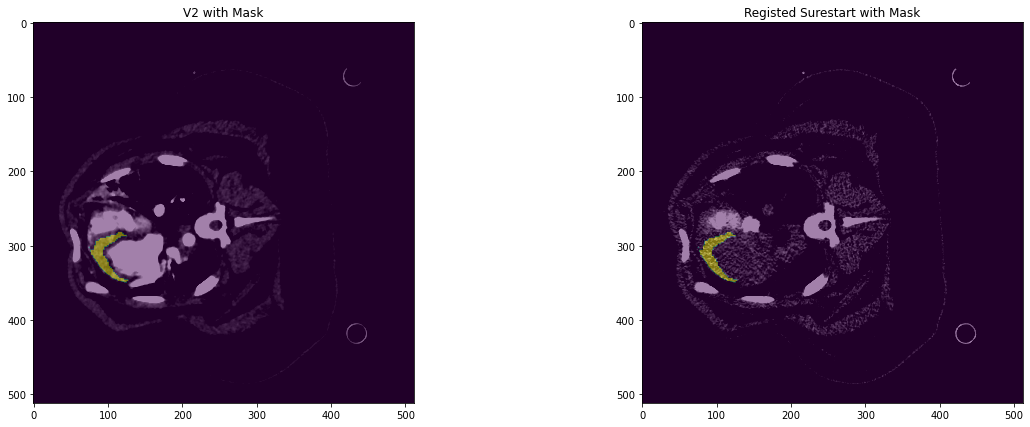

In [ ]:
HU_sure_mean = perfusion.calculate_mean_hu(dcm_rest, chosen_mask, ss_rest[:,:,0], erode_size = 2, visual = True)
print(HU_sure_mean, np.mean(dcm_rest[chosen_mask]))

# Choose full/left/right myocardial to calculate

In [ ]:
result = perfusion.compute_organ_metrics(dcm_rest, chosen_mask, HU_sure_mean, time_vec_gamma_rest, input_conc[0], tissue_rho=1.053)
# result_left = perfusion.compute_organ_metrics(dcm_rest, dcm_mask_left, HU_sure_mean, time_vec_gamma_rest, input_conc[0], tissue_rho=1.053)
# result_right = perfusion.compute_organ_metrics(dcm_rest, dcm_mask_right, HU_sure_mean, time_vec_gamma_rest, input_conc[0], tissue_rho=1.053)

ZeroDivisionError: division by zero

In [ ]:
def plot_slice6(slice_index):
    plt.figure(figsize=(20, 12))

    plt.imshow(result["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    plt.show()

# Creating an interactive slider
interact(plot_slice6, slice_index=IntSlider(min=0, max=result["perf_map"].shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=319), Output()), _dom_classes=('widge…

<function __main__.plot_slice6(slice_index)>

In [ ]:
col_vals = [result["perf"], result["perf_std"], result["flow"], result["flow_std"],  result["delta_time"], result["organ_mass"], result["heart_rate"], target]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "delta_time", "mass", "heart_rate", "date"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
df.to_csv("/home/molloi-lab-linux2/Desktop/ZQY" + '/result.csv', index=False)
df

,parameters,values
0,perfusion,0.552627
1,perfusion_std,1.418551
2,flow,28.265671
3,flow_std,72.555817
4,delta_time,7.989
5,mass,51.14783
6,heart_rate,105
7,date,12_19_22_data/Pig1
